### Import Libraries

In [1]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
random_seed = 42
torch.manual_seed(random_seed);

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

### Step 1a) Fetch the LFW dataset

In [8]:
main_dir = '../datasets/LFW' #For Ubuntu
#main_dir = 'D:/Face/LFW' #For Windows
data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

print(os.listdir(main_dir))
classes = os.listdir(data_dir)
print(len(classes))

['people.csv', 'lfw_readme.csv', 'pairs.csv', 'matchpairsDevTest.csv', 'lfw-deepfunneled', 'peopleDevTest.csv', 'matchpairsDevTrain.csv', 'peopleDevTrain.csv', 'mismatchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'lfw_allnames.csv']
5749


In [9]:
img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
print(img_Aaron_Eckhart[:])

No. of training examples for Aaron_Eckhart: 1
['Aaron_Eckhart_0001.jpg']


In [10]:
dataset = ImageFolder(data_dir, transform=ToTensor())

In [11]:
len(dataset)

13233

In [12]:
print(dataset.classes)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

### Step 1b) Visualize the dataset

In [13]:
img, label = dataset[13232]
print(img.shape, label)

torch.Size([3, 250, 250]) 5748


Text(0.5, 1.0, 'label = 5748')

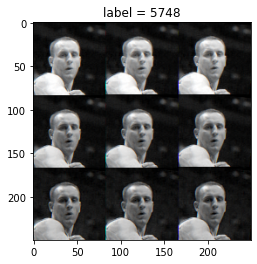

In [14]:
img, label = dataset[13232]
img = torch.reshape(img, (250, 250, 3))

plt.imshow(img)
plt.title('label = ' + str(label))

### Step 1c) Split the dataset into training, validation, and testing

In [15]:
test_factor = 0.1
test_size = int(test_factor * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(dataset))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(10587, 1323, 1323)

In [17]:
batch_size=128

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
len(train_dl), len(val_dl), len(test_dl)

(83, 11, 11)

### Step 2a) Model Architecture - Network

In [21]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [22]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [23]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [24]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [25]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [26]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten()]
        self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        temp = self.features(x)
        return self.fc(temp)

In [27]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [28]:
#model = ResNet50(85742)

In [29]:
loaded_model = ResNet50(85742)
to_device(loaded_model, device)

MyResNet(
  (fc): Linear(in_features=2048, out_features=85742, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), s

In [30]:
#loaded_model.load_state_dict(torch.load("training/el_2epoch_70acc.pth"))
loaded_model.load_state_dict(torch.load("training/el_15epoch_92acc.pth"))

<All keys matched successfully>

In [31]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

In [32]:
#model.layers

In [33]:
# #model = ResNet50(85742)

# for param in loaded_model.parameters():
#     param.requires_grad = False
#     #print(param.shape)
#     #print('----------------------------')
#     #model.fc = nn.Linear(5749, 8)
#     #print("After addition: ", param.shape)

In [34]:
del loaded_model.fc

In [35]:
loaded_model.fc = nn.Linear(2048, 5749)

In [36]:
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [37]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

### Step 2b) Loss Function

In [38]:
loss_Function = F.cross_entropy #CosFace() #

### Step 3) Training the model

In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #Reset Gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [40]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [41]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    #opt = opt_fn(model.fc.parameters(), lr=lr)
    
    for epoch in range(epochs):
        start = time.time()
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, val_losses, val_metrics

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [43]:
val_loss, _, val_acc = evaluate(loaded_model, loss_Function, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [44]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
#print('Loss: {:.4f}'.format(val_loss))

Loss: 8.6554, Accuracy: 0.0000


In [45]:
num_epochs = 1000
opt_func = torch.optim.Adam
lr = 0.0005

In [46]:
history = fit(num_epochs, loaded_model, loss_Function, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/1000], Train_loss: 8.4804, Val_loss: 8.4112, accuracy: 0.0438
66.1 secs
Epoch [2/1000], Train_loss: 7.8910, Val_loss: 8.1760, accuracy: 0.0438
65.3 secs
Epoch [3/1000], Train_loss: 7.4752, Val_loss: 8.1289, accuracy: 0.0438
65.43 secs
Epoch [4/1000], Train_loss: 6.7089, Val_loss: 8.1194, accuracy: 0.0514
65.5 secs
Epoch [5/1000], Train_loss: 6.7021, Val_loss: 8.1655, accuracy: 0.0635
65.11 secs
Epoch [6/1000], Train_loss: 6.4464, Val_loss: 8.2098, accuracy: 0.0922
65.0 secs
Epoch [7/1000], Train_loss: 6.3981, Val_loss: 8.3023, accuracy: 0.1262
64.69 secs
Epoch [8/1000], Train_loss: 5.4108, Val_loss: 8.3273, accuracy: 0.1557
64.74 secs
Epoch [9/1000], Train_loss: 5.3970, Val_loss: 8.3955, accuracy: 0.1807
64.81 secs
Epoch [10/1000], Train_loss: 4.5052, Val_loss: 8.5165, accuracy: 0.2011
64.76 secs
Epoch [11/1000], Train_loss: 4.0850, Val_loss: 8.5718, accuracy: 0.2260
65.34 secs
Epoch [12/1000], Train_loss: 3.2035, Val_loss: 8.6768, accuracy: 0.2532
64.77 secs
Epoch [13/1000], 

Epoch [100/1000], Train_loss: 0.0009, Val_loss: 9.1497, accuracy: 0.3681
64.75 secs
Epoch [101/1000], Train_loss: 0.0008, Val_loss: 9.1056, accuracy: 0.3764
64.65 secs
Epoch [102/1000], Train_loss: 0.0008, Val_loss: 9.1408, accuracy: 0.3794
64.93 secs
Epoch [103/1000], Train_loss: 0.0006, Val_loss: 9.2055, accuracy: 0.3772
64.81 secs
Epoch [104/1000], Train_loss: 0.0006, Val_loss: 9.1989, accuracy: 0.3794
65.06 secs
Epoch [105/1000], Train_loss: 0.0008, Val_loss: 9.2240, accuracy: 0.3787
64.73 secs
Epoch [106/1000], Train_loss: 0.0003, Val_loss: 9.2429, accuracy: 0.3817
65.45 secs
Epoch [107/1000], Train_loss: 0.0007, Val_loss: 9.3067, accuracy: 0.3779
64.76 secs
Epoch [108/1000], Train_loss: 0.0003, Val_loss: 9.3228, accuracy: 0.3764
65.43 secs
Epoch [109/1000], Train_loss: 0.0003, Val_loss: 9.3172, accuracy: 0.3810
64.37 secs
Epoch [110/1000], Train_loss: 0.0005, Val_loss: 9.3240, accuracy: 0.3817
65.27 secs
Epoch [111/1000], Train_loss: 0.0003, Val_loss: 9.3749, accuracy: 0.3810
64.

Epoch [198/1000], Train_loss: 0.0000, Val_loss: 9.7071, accuracy: 0.3900
65.54 secs
Epoch [199/1000], Train_loss: 0.0000, Val_loss: 9.7070, accuracy: 0.3885
64.95 secs
Epoch [200/1000], Train_loss: 0.0000, Val_loss: 9.6872, accuracy: 0.3893
65.34 secs
Epoch [201/1000], Train_loss: 0.0000, Val_loss: 9.6657, accuracy: 0.3908
65.36 secs
Epoch [202/1000], Train_loss: 0.0000, Val_loss: 9.6735, accuracy: 0.3878
65.27 secs
Epoch [203/1000], Train_loss: 0.0000, Val_loss: 9.6901, accuracy: 0.3900
64.81 secs
Epoch [204/1000], Train_loss: 0.0000, Val_loss: 9.7070, accuracy: 0.3862
64.68 secs
Epoch [205/1000], Train_loss: 0.0000, Val_loss: 9.7287, accuracy: 0.3893
64.96 secs
Epoch [206/1000], Train_loss: 0.0000, Val_loss: 9.7823, accuracy: 0.3885
64.7 secs
Epoch [207/1000], Train_loss: 0.0000, Val_loss: 9.6891, accuracy: 0.3900
65.23 secs
Epoch [208/1000], Train_loss: 0.0000, Val_loss: 9.7157, accuracy: 0.3908
64.73 secs
Epoch [209/1000], Train_loss: 0.0000, Val_loss: 9.7554, accuracy: 0.3908
65.3

Epoch [296/1000], Train_loss: 0.0000, Val_loss: 9.8373, accuracy: 0.3900
64.95 secs
Epoch [297/1000], Train_loss: 0.0000, Val_loss: 9.8457, accuracy: 0.3885
64.78 secs
Epoch [298/1000], Train_loss: 0.0000, Val_loss: 9.8516, accuracy: 0.3908
65.0 secs
Epoch [299/1000], Train_loss: 0.0000, Val_loss: 9.8896, accuracy: 0.3885
64.78 secs
Epoch [300/1000], Train_loss: 0.0000, Val_loss: 9.8142, accuracy: 0.3923
65.29 secs
Epoch [301/1000], Train_loss: 0.0000, Val_loss: 9.8587, accuracy: 0.3900
64.81 secs
Epoch [302/1000], Train_loss: 0.0000, Val_loss: 9.8424, accuracy: 0.3893
65.35 secs
Epoch [303/1000], Train_loss: 0.0000, Val_loss: 9.7894, accuracy: 0.3885
64.58 secs
Epoch [304/1000], Train_loss: 0.0000, Val_loss: 9.8372, accuracy: 0.3893
65.4 secs
Epoch [305/1000], Train_loss: 0.0000, Val_loss: 9.8446, accuracy: 0.3885
64.32 secs
Epoch [306/1000], Train_loss: 0.0000, Val_loss: 9.8028, accuracy: 0.3893
65.3 secs
Epoch [307/1000], Train_loss: 0.0000, Val_loss: 9.7901, accuracy: 0.3908
63.93 

Epoch [394/1000], Train_loss: 0.0000, Val_loss: 9.4708, accuracy: 0.3968
65.39 secs
Epoch [395/1000], Train_loss: 0.0000, Val_loss: 9.4577, accuracy: 0.3961
64.07 secs
Epoch [396/1000], Train_loss: 0.0000, Val_loss: 9.4478, accuracy: 0.3968
65.35 secs
Epoch [397/1000], Train_loss: 0.0000, Val_loss: 9.4787, accuracy: 0.3983
64.03 secs
Epoch [398/1000], Train_loss: 0.0000, Val_loss: 9.4536, accuracy: 0.3998
65.36 secs
Epoch [399/1000], Train_loss: 0.0000, Val_loss: 9.4683, accuracy: 0.3983
64.0 secs
Epoch [400/1000], Train_loss: 0.0000, Val_loss: 9.4438, accuracy: 0.3983
65.46 secs
Epoch [401/1000], Train_loss: 0.0000, Val_loss: 9.4704, accuracy: 0.3946
64.54 secs
Epoch [402/1000], Train_loss: 0.0000, Val_loss: 9.4590, accuracy: 0.3976
65.46 secs
Epoch [403/1000], Train_loss: 0.0000, Val_loss: 9.4481, accuracy: 0.3983
64.64 secs
Epoch [404/1000], Train_loss: 0.0000, Val_loss: 9.4099, accuracy: 0.3976
65.32 secs
Epoch [405/1000], Train_loss: 0.0000, Val_loss: 9.4423, accuracy: 0.3998
64.0

Epoch [492/1000], Train_loss: 0.0000, Val_loss: 9.8247, accuracy: 0.3832
64.97 secs
Epoch [493/1000], Train_loss: 0.0000, Val_loss: 9.8109, accuracy: 0.3847
64.79 secs
Epoch [494/1000], Train_loss: 0.0000, Val_loss: 9.8113, accuracy: 0.3847
64.97 secs
Epoch [495/1000], Train_loss: 0.0000, Val_loss: 9.7829, accuracy: 0.3855
64.84 secs
Epoch [496/1000], Train_loss: 0.0000, Val_loss: 9.8782, accuracy: 0.3862
65.26 secs
Epoch [497/1000], Train_loss: 0.0000, Val_loss: 9.8346, accuracy: 0.3855
64.83 secs
Epoch [498/1000], Train_loss: 0.0000, Val_loss: 9.8116, accuracy: 0.3878
65.44 secs
Epoch [499/1000], Train_loss: 0.0000, Val_loss: 9.8060, accuracy: 0.3870
64.66 secs
Epoch [500/1000], Train_loss: 0.0000, Val_loss: 9.8727, accuracy: 0.3855
65.37 secs
Epoch [501/1000], Train_loss: 0.0000, Val_loss: 9.8445, accuracy: 0.3855
64.19 secs
Epoch [502/1000], Train_loss: 0.0000, Val_loss: 9.8272, accuracy: 0.3840
65.32 secs
Epoch [503/1000], Train_loss: 0.0000, Val_loss: 9.7978, accuracy: 0.3832
63.

Epoch [590/1000], Train_loss: 0.0000, Val_loss: 9.6441, accuracy: 0.4014
64.09 secs
Epoch [591/1000], Train_loss: 0.0000, Val_loss: 9.5778, accuracy: 0.4006
65.37 secs
Epoch [592/1000], Train_loss: 0.0000, Val_loss: 9.6195, accuracy: 0.4021
64.45 secs
Epoch [593/1000], Train_loss: 0.0000, Val_loss: 9.5886, accuracy: 0.3998
65.65 secs
Epoch [594/1000], Train_loss: 0.0000, Val_loss: 9.5697, accuracy: 0.4021
64.87 secs
Epoch [595/1000], Train_loss: 0.0000, Val_loss: 9.5883, accuracy: 0.3991
65.43 secs
Epoch [596/1000], Train_loss: 0.0000, Val_loss: 9.5424, accuracy: 0.3991
64.54 secs
Epoch [597/1000], Train_loss: 0.0000, Val_loss: 9.5362, accuracy: 0.4014
65.67 secs
Epoch [598/1000], Train_loss: 0.0000, Val_loss: 9.5522, accuracy: 0.4014
64.67 secs
Epoch [599/1000], Train_loss: 0.0000, Val_loss: 9.4969, accuracy: 0.3991
65.38 secs
Epoch [600/1000], Train_loss: 0.0000, Val_loss: 9.5036, accuracy: 0.4006
64.03 secs
Epoch [601/1000], Train_loss: 0.0000, Val_loss: 9.5118, accuracy: 0.3991
65.

Epoch [688/1000], Train_loss: 0.0000, Val_loss: 10.2838, accuracy: 0.3983
65.5 secs
Epoch [689/1000], Train_loss: 0.0000, Val_loss: 10.2415, accuracy: 0.3968
64.26 secs
Epoch [690/1000], Train_loss: 0.0000, Val_loss: 10.2442, accuracy: 0.3991
65.43 secs
Epoch [691/1000], Train_loss: 0.0000, Val_loss: 10.2868, accuracy: 0.4006
64.31 secs
Epoch [692/1000], Train_loss: 0.0105, Val_loss: 10.1634, accuracy: 0.3998
65.36 secs
Epoch [693/1000], Train_loss: 0.0000, Val_loss: 10.2703, accuracy: 0.3946
64.88 secs
Epoch [694/1000], Train_loss: 0.0000, Val_loss: 10.0669, accuracy: 0.3930
65.39 secs
Epoch [695/1000], Train_loss: 0.0000, Val_loss: 10.1183, accuracy: 0.3908
64.23 secs
Epoch [696/1000], Train_loss: 0.0000, Val_loss: 10.1228, accuracy: 0.3946
65.54 secs
Epoch [697/1000], Train_loss: 0.0000, Val_loss: 10.0432, accuracy: 0.3946
64.25 secs
Epoch [698/1000], Train_loss: 0.0000, Val_loss: 10.0569, accuracy: 0.3968
65.44 secs
Epoch [699/1000], Train_loss: 0.0000, Val_loss: 10.0547, accuracy:

Epoch [786/1000], Train_loss: 0.0000, Val_loss: 9.7775, accuracy: 0.4029
64.97 secs
Epoch [787/1000], Train_loss: 0.0000, Val_loss: 9.7348, accuracy: 0.4014
65.37 secs
Epoch [788/1000], Train_loss: 0.0000, Val_loss: 9.7691, accuracy: 0.4036
64.9 secs
Epoch [789/1000], Train_loss: 0.0000, Val_loss: 9.7907, accuracy: 0.4014
65.5 secs
Epoch [790/1000], Train_loss: 0.0000, Val_loss: 9.7569, accuracy: 0.4044
64.71 secs
Epoch [791/1000], Train_loss: 0.0000, Val_loss: 9.7582, accuracy: 0.4021
65.48 secs
Epoch [792/1000], Train_loss: 0.0000, Val_loss: 9.7390, accuracy: 0.4029
64.29 secs
Epoch [793/1000], Train_loss: 0.0000, Val_loss: 9.7452, accuracy: 0.4029
65.35 secs
Epoch [794/1000], Train_loss: 0.0000, Val_loss: 9.7731, accuracy: 0.4021
64.18 secs
Epoch [795/1000], Train_loss: 0.0000, Val_loss: 9.7127, accuracy: 0.4014
65.49 secs
Epoch [796/1000], Train_loss: 0.0000, Val_loss: 9.7330, accuracy: 0.4044
64.43 secs
Epoch [797/1000], Train_loss: 0.0000, Val_loss: 9.7116, accuracy: 0.4036
65.41

Epoch [884/1000], Train_loss: 0.0000, Val_loss: 9.5862, accuracy: 0.3938
33.1 secs
Epoch [885/1000], Train_loss: 0.0000, Val_loss: 9.6334, accuracy: 0.3953
33.08 secs
Epoch [886/1000], Train_loss: 0.0000, Val_loss: 9.5730, accuracy: 0.3976
33.14 secs
Epoch [887/1000], Train_loss: 0.0000, Val_loss: 9.5631, accuracy: 0.3930
33.09 secs
Epoch [888/1000], Train_loss: 0.0000, Val_loss: 9.5836, accuracy: 0.3946
33.1 secs
Epoch [889/1000], Train_loss: 0.0000, Val_loss: 9.5649, accuracy: 0.3930
33.11 secs
Epoch [890/1000], Train_loss: 0.0000, Val_loss: 9.6135, accuracy: 0.3991
33.12 secs
Epoch [891/1000], Train_loss: 0.0000, Val_loss: 9.5622, accuracy: 0.3946
33.1 secs
Epoch [892/1000], Train_loss: 0.0000, Val_loss: 9.5696, accuracy: 0.3946
33.11 secs
Epoch [893/1000], Train_loss: 0.0000, Val_loss: 9.6008, accuracy: 0.3946
33.06 secs
Epoch [894/1000], Train_loss: 0.0000, Val_loss: 9.5919, accuracy: 0.3953
33.14 secs
Epoch [895/1000], Train_loss: 0.0000, Val_loss: 9.5562, accuracy: 0.3953
33.09 

Epoch [982/1000], Train_loss: 0.0000, Val_loss: 8.9099, accuracy: 0.4021
33.12 secs
Epoch [983/1000], Train_loss: 0.0000, Val_loss: 8.9247, accuracy: 0.4067
33.17 secs
Epoch [984/1000], Train_loss: 0.0000, Val_loss: 8.9077, accuracy: 0.4021
33.15 secs
Epoch [985/1000], Train_loss: 0.0000, Val_loss: 8.8932, accuracy: 0.4036
33.12 secs
Epoch [986/1000], Train_loss: 0.0000, Val_loss: 8.8330, accuracy: 0.4006
33.03 secs
Epoch [987/1000], Train_loss: 0.0000, Val_loss: 8.8465, accuracy: 0.4044
33.09 secs
Epoch [988/1000], Train_loss: 0.0000, Val_loss: 8.8267, accuracy: 0.3998
33.12 secs
Epoch [989/1000], Train_loss: 0.0000, Val_loss: 8.7966, accuracy: 0.4036
33.09 secs
Epoch [990/1000], Train_loss: 0.0000, Val_loss: 8.7476, accuracy: 0.3991
33.04 secs
Epoch [991/1000], Train_loss: 0.0000, Val_loss: 8.7516, accuracy: 0.4021
33.1 secs
Epoch [992/1000], Train_loss: 0.0000, Val_loss: 8.7574, accuracy: 0.4014
33.05 secs
Epoch [993/1000], Train_loss: 0.0000, Val_loss: 8.7118, accuracy: 0.3983
33.0

### Step 4) Evaluate the model and Plotting of curves

In [47]:
train_losses, val_losses, val_metrics = history

In [48]:
def plot_accuracies(epoch, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, val_metrics, '-x')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

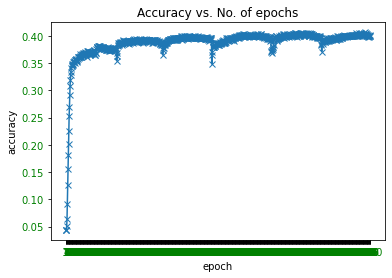

In [49]:
plot_accuracies(num_epochs, val_metrics)

In [50]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

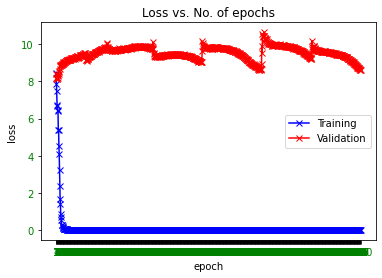

In [51]:
plot_losses(num_epochs, train_losses, val_losses)

In [52]:
result = evaluate(loaded_model, loss_Function, test_dl, accuracy)
result

(8.60668682709663, 1323, 0.3945578231292517)

In [53]:
torch.save(loaded_model.state_dict(), 'el_lfw_fineTune.pth')

In [54]:
# Creating a new data frame
newDataframe = pd.DataFrame()

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
# newDataframe.to_excel('lfw_model_outputs.xlsx', sheet_name="Sheet 2", index = False)

with pd.ExcelWriter("lfw_model_outputs.xlsx", mode="a", engine="openpyxl") as writer:
    newDataframe.to_excel(writer, sheet_name="Sheet FT")

# Reading the data from the outputExcelFile
excelData = pd.read_excel('lfw_model_outputs.xlsx', sheet_name="Sheet FT")

#Printing the data frame
print(excelData)

     Unnamed: 0    Train Loss  Val Loss  Val Acc.
0             0  8.480373e+00  8.411208  0.043840
1             1  7.891034e+00  8.176048  0.043840
2             2  7.475210e+00  8.128856  0.043840
3             3  6.708942e+00  8.119423  0.051398
4             4  6.702085e+00  8.165453  0.063492
..          ...           ...       ...       ...
995         995  2.685476e-07  8.696664  0.399849
996         996  1.021794e-07  8.643390  0.400605
997         997  1.598183e-07  8.659659  0.402116
998         998  1.440988e-07  8.619738  0.399093
999         999  4.977970e-08  8.618560  0.399849

[1000 rows x 4 columns]


In [55]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#                 dataloader = train_dl
#             else:
#                 model.eval()   # Set model to evaluate mode
#                 dataloader = val_dl

#             len_input = 0
#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloader:
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 len_input += len(inputs)
#                 running_loss += loss.item() * len(inputs)
#                 running_corrects += torch.sum(preds == labels).item() / len(preds)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / len_input
#             epoch_acc = running_corrects / len_input

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [56]:
# criterion = F.cross_entropy

# # Observe that all parameters are being optimized
# optimizer_ft = torch.optim.SGD(loaded_model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [57]:
# model_ft = train_model(loaded_model, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)